In [49]:
import numpy as np
import scipy.linalg
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from functools import partial

np.random.seed(seed=1)

%matplotlib inline

In [50]:
mat = scipy.io.loadmat("assign3.mat")
dat = [mat["a"].T, mat["b"].T]

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


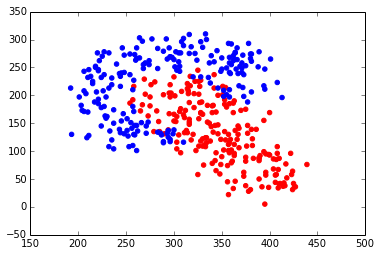

In [51]:
fig = plt.figure()
plt.scatter(dat[0][0], dat[0][1], color="red")
plt.scatter(dat[1][0], dat[1][1], color="blue")
plt.show()

In [52]:
def med(c1, c2):
    """Create an med function"""
    z1 = np.mean(c1, axis=1)
    z2 = np.mean(c2, axis=1)
    def f(x):
        return -np.dot(z1,x) + 0.5*np.dot(z1.T,z1) < -np.dot(z2,x) + 0.5*np.dot(z2.T,z2)
    return f

In [72]:
def choose(dat, size):
    return dat[:, np.random.choice(dat.shape[1], size=size, replace=False)]

def get_diff(a, b):
    return np.where(a != b)[0]

def majority_vote(a, b, c):
    res = np.zeros(a.shape)
    res[np.where( np.sum((a, b, c), axis=0) >= 2 )] = 1
    return res

def make_booster(a_dat, b_dat, clsfier):
    # choose a quarter for training and classify
    a_err = np.empty((2,0))
    b_err = np.empty((2,0))
    while b_err.shape[1] <= 1 or a_err.shape[1] <= 1:
        c1 = clsfier(choose(a_dat, size=a_dat.shape[1]/4), choose(b_dat, size=b_dat.shape[1]/4))

        a_err = a_dat[:, np.where(c1(a_dat) == False)[0]]
        b_err = b_dat[:, np.where(c1(b_dat) == True)[0]]

    # choose a half of the erroroneously classed and train
    c2 = clsfier(choose(a_err, size=a_err.shape[1]/2), choose(b_err, size=b_err.shape[1]/2))

    # train on disagreement of c1 and c2
    a_c1 = c1(a_dat)
    a_c2 = c2(a_dat)
    b_c1 = c1(b_dat)
    b_c2 = c2(b_dat)
    
    a_diff = a_dat[:, get_diff(a_c1, a_c2)]
    b_diff = b_dat[:, get_diff(b_c1, b_c2)]
    c3 = clsfier(a_diff, b_diff)
    
    def boost_eval(x):
        return majority_vote(c1(x), c2(x), c3(x))
    
    return boost_eval

In [60]:
def make_q_class(c1, c2, q):
    err = []
    cls = []
    
    for q_i in xrange(q):
        # get the error
        a = choose(c1, 1)
        b = choose(c2, 1)
        cls.append(med(a, b))
        
        err.append(get_med_err(c1, c2, cls[-1]))

    return cls[np.argmin(err)]

In [65]:
def get_med_err(a, b, med_func):
    tot_err = 0
    tot_err += np.where(med_func(a) == False)[0].shape[0]
    tot_err += np.where(med_func(b) == True)[0].shape[0]
    return tot_err

In [61]:
med_boosted = make_booster(dat[0], dat[1], med)

In [62]:
q_boosted = make_booster(dat[0], dat[1], partial(make_q_class, q=10))

In [66]:
tot_err = get_med_err(dat[0], dat[1], med_boosted)
# Brent got 0.1902
print(tot_err/400.0)

0.1975


In [64]:
tot_err = get_med_err(dat[0], dat[1], q_boosted)
# Brent got 0.16805
print(tot_err/400.0)

0.125


In [ ]:
# plot the q classifier boundary


In [73]:
# explore the range of q, from 5 to 30
q_err = []
for q_val in range(5, 35, 5):
    q_err.append([])
    for _ in range(10):
        q_tmp = make_booster(dat[0], dat[1], partial(make_q_class, q=q_val))
        q_err[-1].append(get_med_err(dat[0], dat[1], q_tmp))
print(q_err)

[[69, 62, 73, 67, 49, 107, 88, 77, 80, 84], [57, 90, 79, 50, 51, 63, 81, 89, 73, 73], [73, 60, 65, 57, 65, 55, 61, 67, 68, 82], [60, 59, 76, 72, 87, 62, 80, 49, 66, 75], [76, 59, 77, 81, 74, 81, 65, 65, 61, 68], [69, 74, 82, 54, 71, 77, 59, 56, 72, 87]]


In [67]:
# unboosted q
q_default = make_q_class(dat[0], dat[1], 10)
tot_err = get_med_err(dat[0], dat[1], q_default)
print(tot_err/400.0)

0.1975


In [68]:
# unboosted q
med_default = med(dat[0], dat[1])
tot_err = get_med_err(dat[0], dat[1], med_default)
print(tot_err/400.0)

0.205
